## Clustering/Segmentation Home Assignment
Task description: *Develop segmentation of actors as of 2014-12-31 into 5 segments using algorithm of your choice in Python. Use your own numerical predictors (at least 5 predictors). Name your segments and provide business interpretation of each segment. Pick a good example actors who represent their segment. Provide yoy transition matrix 2014-12-31 to 2015-12-31 in excel*

### Executive Summary
The task was to identify clusters of actors that has been tracked within [GDELT database](http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf) in 2014. For that purpose we have used data from GDELT database and computed following eleven variables that were used as an input to a clustering algorithm: 
* **n_events_Sum_12M** - number of events during last 12 months actor was participating on          
* **AvgTone_Avg_12M** - mean value of average tone of all documents containing one or more mentions of events actor was participating on during last 12 months            
* **AvgTone_Max_12M** - maximum value of average tone of all documents containing one or more mentions of events actor was participating on during last 12 months           
* **AvgTone_Min_12M** - minimum value of average tone of all documents containing one or more mentions of events actor was participating on during last 12 months           
* **NumMentions_Sum_12M** - number of mentions about events actors were participating on during last 12 months       
* **NumMentions_Avg_12M** - average number of mentions about events actors were participating on during last 12 months      
* **NumSources_Sum_12M** - number of sources about events actors were participating on during last 12 months        
* **NumSources_Avg_12M** - average number of sources about events actors were participating on during last 12 months       
* **GoldsteinScale_Avg_12M** - average value of score on Goldstein scale for events actors were participating on during last 12 months       
* **GoldsteinScale_Max_12M** - maximum value of score on Goldstein scale for events actors were participating on during last 12 months    
* **GoldsteinScale_Min_12M** - minimum value of score on Goldstein scale for events actors were participating on during last 12 months    

Using k-means clustering algorithm following four clusters were identified:
* **Destabilization Cluster** 
    * Cluster with *n* = 2034 actors who have particpated on relatively small number of events that were rather destabilizing in their nature. In comparison with remaining clusters the average tone of documents mentioning events and their corresponding actors is least positive.
    * Among prototypical representatives of this cluster belong followign actors: NDGOV_MANIPUR, IGOEUREECCVL_EUROPEAN UNION and CHLCRM_CHILEAN

* **Stabilization Cluster** 
    * Cluster with *n* = 5347 actors who have been part of relatively small number of events that had rather stabilizing effect on their respective participants. In comparison with remaining clusters the average tone of documents mentioning events and their corresponding actors is most positive.
    * Among prototypical representatives of this cluster belong following actors: HNGOV_ZHANG DEJIANG, DEUGOV_GUIDO WESTERWELLE and USA_PEACH STATE.
    
* **"At Crossroad" Cluster** 
    * Cluster with *n* = 3427 actors who have participated on relatively high number of events that were evenly distributed among those with stabilizing and destabilizing effect on their respective participants. This fact suggests that these actors could be at kind of a crossroad from which they can proceed either towards political and economic stability or towards political or economic instability.      
    * Among prototypical representatives of this cluster belong followign actors: CVL_ETHNIC GROUP, GOV_CITY MAYOR and USA_CALIF.

* **"Ukraine At Crossroad" Custer** 
    * Cluster with just one actor who was participating on extremely large number of events. Similarly as in the case of Cluster 2 there seems to be an even mix of stabilizing and destabilizing events which suggests that Ukraine is at kind of a crossroad from which it can proceeed either towards political and economic stability or towards political or economic instability.
    * The only representative of this cluster is UKR_UKRAINE. 

We have also created spider graphs shwowing typical "profiles" of actors from individual clusters" and computed transition matrix that shows how cluster membership of individual actors has changed from 2014 to 2015. 

### Preparatory Work

In [1]:
# Loading all neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from math import pi 
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numba

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [3]:
# Uploading data and filtering data by year
data = pd.read_csv('F:/space_aa_420/01_projects/2018/06_DSA_GDELT/trainees/com-lstehlik/HA3_Segmentation/data/Segmentation_Predictors.csv')
data_2014 = data[data.obs_date == '12/31/2014']
data_2015 = data[data.obs_date == '12/31/2015']
data_2015 = data_2015.reset_index() # needed for later merger with output form clustering algorithm 

### EDA (using data from 2014)

In [4]:
# Checking basic info about available data
data_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10809 entries, 0 to 10808
Data columns (total 13 columns):
ActorId                   10809 non-null object
obs_date                  10809 non-null object
n_events_Sum_12M          10809 non-null int64
AvgTone_Avg_12M           10809 non-null float64
AvgTone_Max_12M           10809 non-null float64
AvgTone_Min_12M           10809 non-null float64
NumMentions_Sum_12M       10809 non-null int64
NumMentions_Avg_12M       10809 non-null int64
NumSources_Sum_12M        10809 non-null int64
NumSources_Avg_12M        10809 non-null int64
GoldsteinScale_Avg_12M    10809 non-null float64
GoldsteinScale_Max_12M    10809 non-null float64
GoldsteinScale_Min_12M    10809 non-null float64
dtypes: float64(6), int64(5), object(2)
memory usage: 1.2+ MB


In [5]:
# Checking missing values
data_2014.isnull().sum()

ActorId                   0
obs_date                  0
n_events_Sum_12M          0
AvgTone_Avg_12M           0
AvgTone_Max_12M           0
AvgTone_Min_12M           0
NumMentions_Sum_12M       0
NumMentions_Avg_12M       0
NumSources_Sum_12M        0
NumSources_Avg_12M        0
GoldsteinScale_Avg_12M    0
GoldsteinScale_Max_12M    0
GoldsteinScale_Min_12M    0
dtype: int64

In [6]:
# Inspecting first few lines of data
data_2014.head(6)

,ActorId,obs_date,n_events_Sum_12M,AvgTone_Avg_12M,AvgTone_Max_12M,AvgTone_Min_12M,NumMentions_Sum_12M,NumMentions_Avg_12M,NumSources_Sum_12M,NumSources_Avg_12M,GoldsteinScale_Avg_12M,GoldsteinScale_Max_12M,GoldsteinScale_Min_12M
0,AAR_AFAR,12/31/2014,35,3.089889,5.852517,0.000000,278,7,40,1,0.205714,7.0,-10.0
1,ABK_ABKHAZIANS,12/31/2014,33,2.515010,5.263158,-0.129870,296,8,34,1,-0.015151,7.0,-10.0
2,ABR010_FREEMASON,12/31/2014,4,3.019740,3.581267,1.335159,36,9,5,1,3.100000,7.0,-5.0
3,ABR010_FREEMASONRY,12/31/2014,5,3.164585,3.544554,2.272727,14,2,5,1,2.600000,7.4,-6.5
4,ABW_ARUBA,12/31/2014,1,3.072626,3.072626,3.072626,2,2,1,1,1.900000,1.9,1.9
5,ADI_ADIVASI,12/31/2014,1,1.745201,1.745201,1.745201,3,3,1,1,3.000000,3.0,3.0


In [7]:
# Basic summary of available data
data_2014.describe()

,n_events_Sum_12M,AvgTone_Avg_12M,AvgTone_Max_12M,AvgTone_Min_12M,NumMentions_Sum_12M,NumMentions_Avg_12M,NumSources_Sum_12M,NumSources_Avg_12M,GoldsteinScale_Avg_12M,GoldsteinScale_Max_12M,GoldsteinScale_Min_12M
count,10809.000000,10809.000000,10809.000000,10809.000000,1.080900e+04,10809.000000,10809.000000,10809.000000,10809.000000,10809.000000,10809.000000
mean,222.898881,2.403102,3.939484,0.996168,2.501003e+03,7.488112,443.941623,1.212046,0.357872,3.623453,-3.544333
std,3688.338239,1.231908,2.492902,2.689966,4.370990e+04,11.854709,8011.759084,0.891920,3.692075,4.738040,5.480056
min,1.000000,-11.267606,-11.267606,-17.600000,1.000000e+00,1.000000,1.000000,1.000000,-10.000000,-10.000000,-10.000000
25%,2.000000,1.735016,2.247191,0.365496,8.000000e+00,3.000000,2.000000,1.000000,-1.320000,1.000000,-10.000000
50%,4.000000,2.294705,3.423849,1.292759,2.600000e+01,6.000000,5.000000,1.000000,1.000000,4.000000,-4.000000
75%,20.000000,2.932972,5.118110,2.272727,1.510000e+02,9.000000,28.000000,1.000000,2.590000,7.000000,1.000000
max,297939.000000,14.876033,17.241379,14.876033,3.709154e+06,882.000000,659463.000000,27.000000,10.000000,10.000000,10.000000


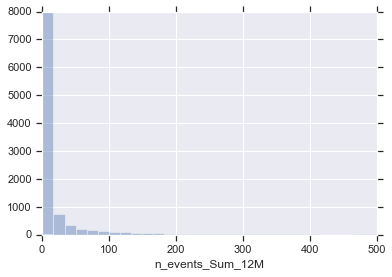

In [8]:
# Plottitng overall number of events actors were participating on 
sns.distplot(data_2014[data_2014.n_events_Sum_12M <= 500].n_events_Sum_12M, bins = 30, kde = False)

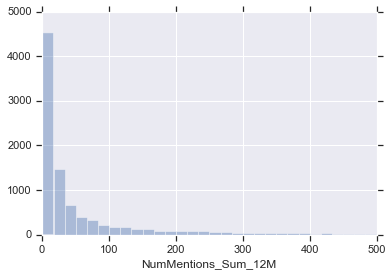

In [9]:
# Plotting overall number of mentions about events actors were participating on 
sns.distplot(data_2014[data_2014.NumMentions_Sum_12M <= 500].NumMentions_Sum_12M, bins = 30, kde = False)

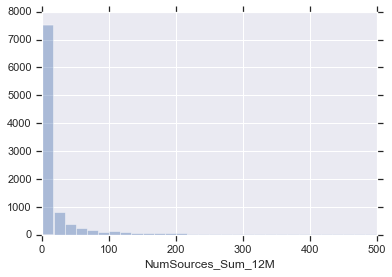

In [10]:
# Plotting overall number of sources about events actors were participating on
sns.distplot(data_2014[data_2014.NumSources_Sum_12M <= 500].NumSources_Sum_12M, bins = 30, kde = False)

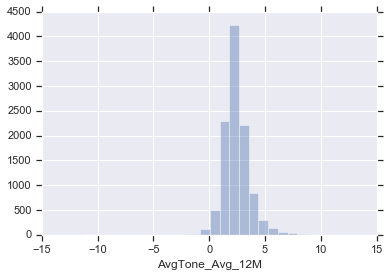

In [11]:
# Plotting central tendency of average tone of news about events individual actors were participating on  
sns.distplot(data_2014.AvgTone_Avg_12M, bins = 30, kde = False)

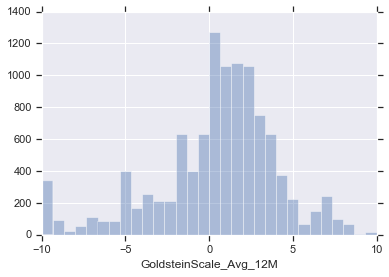

In [12]:
# Plotting average Goldstein score of events individual actors were participating on  
sns.distplot(data_2014.GoldsteinScale_Avg_12M, bins = 30, kde = False)

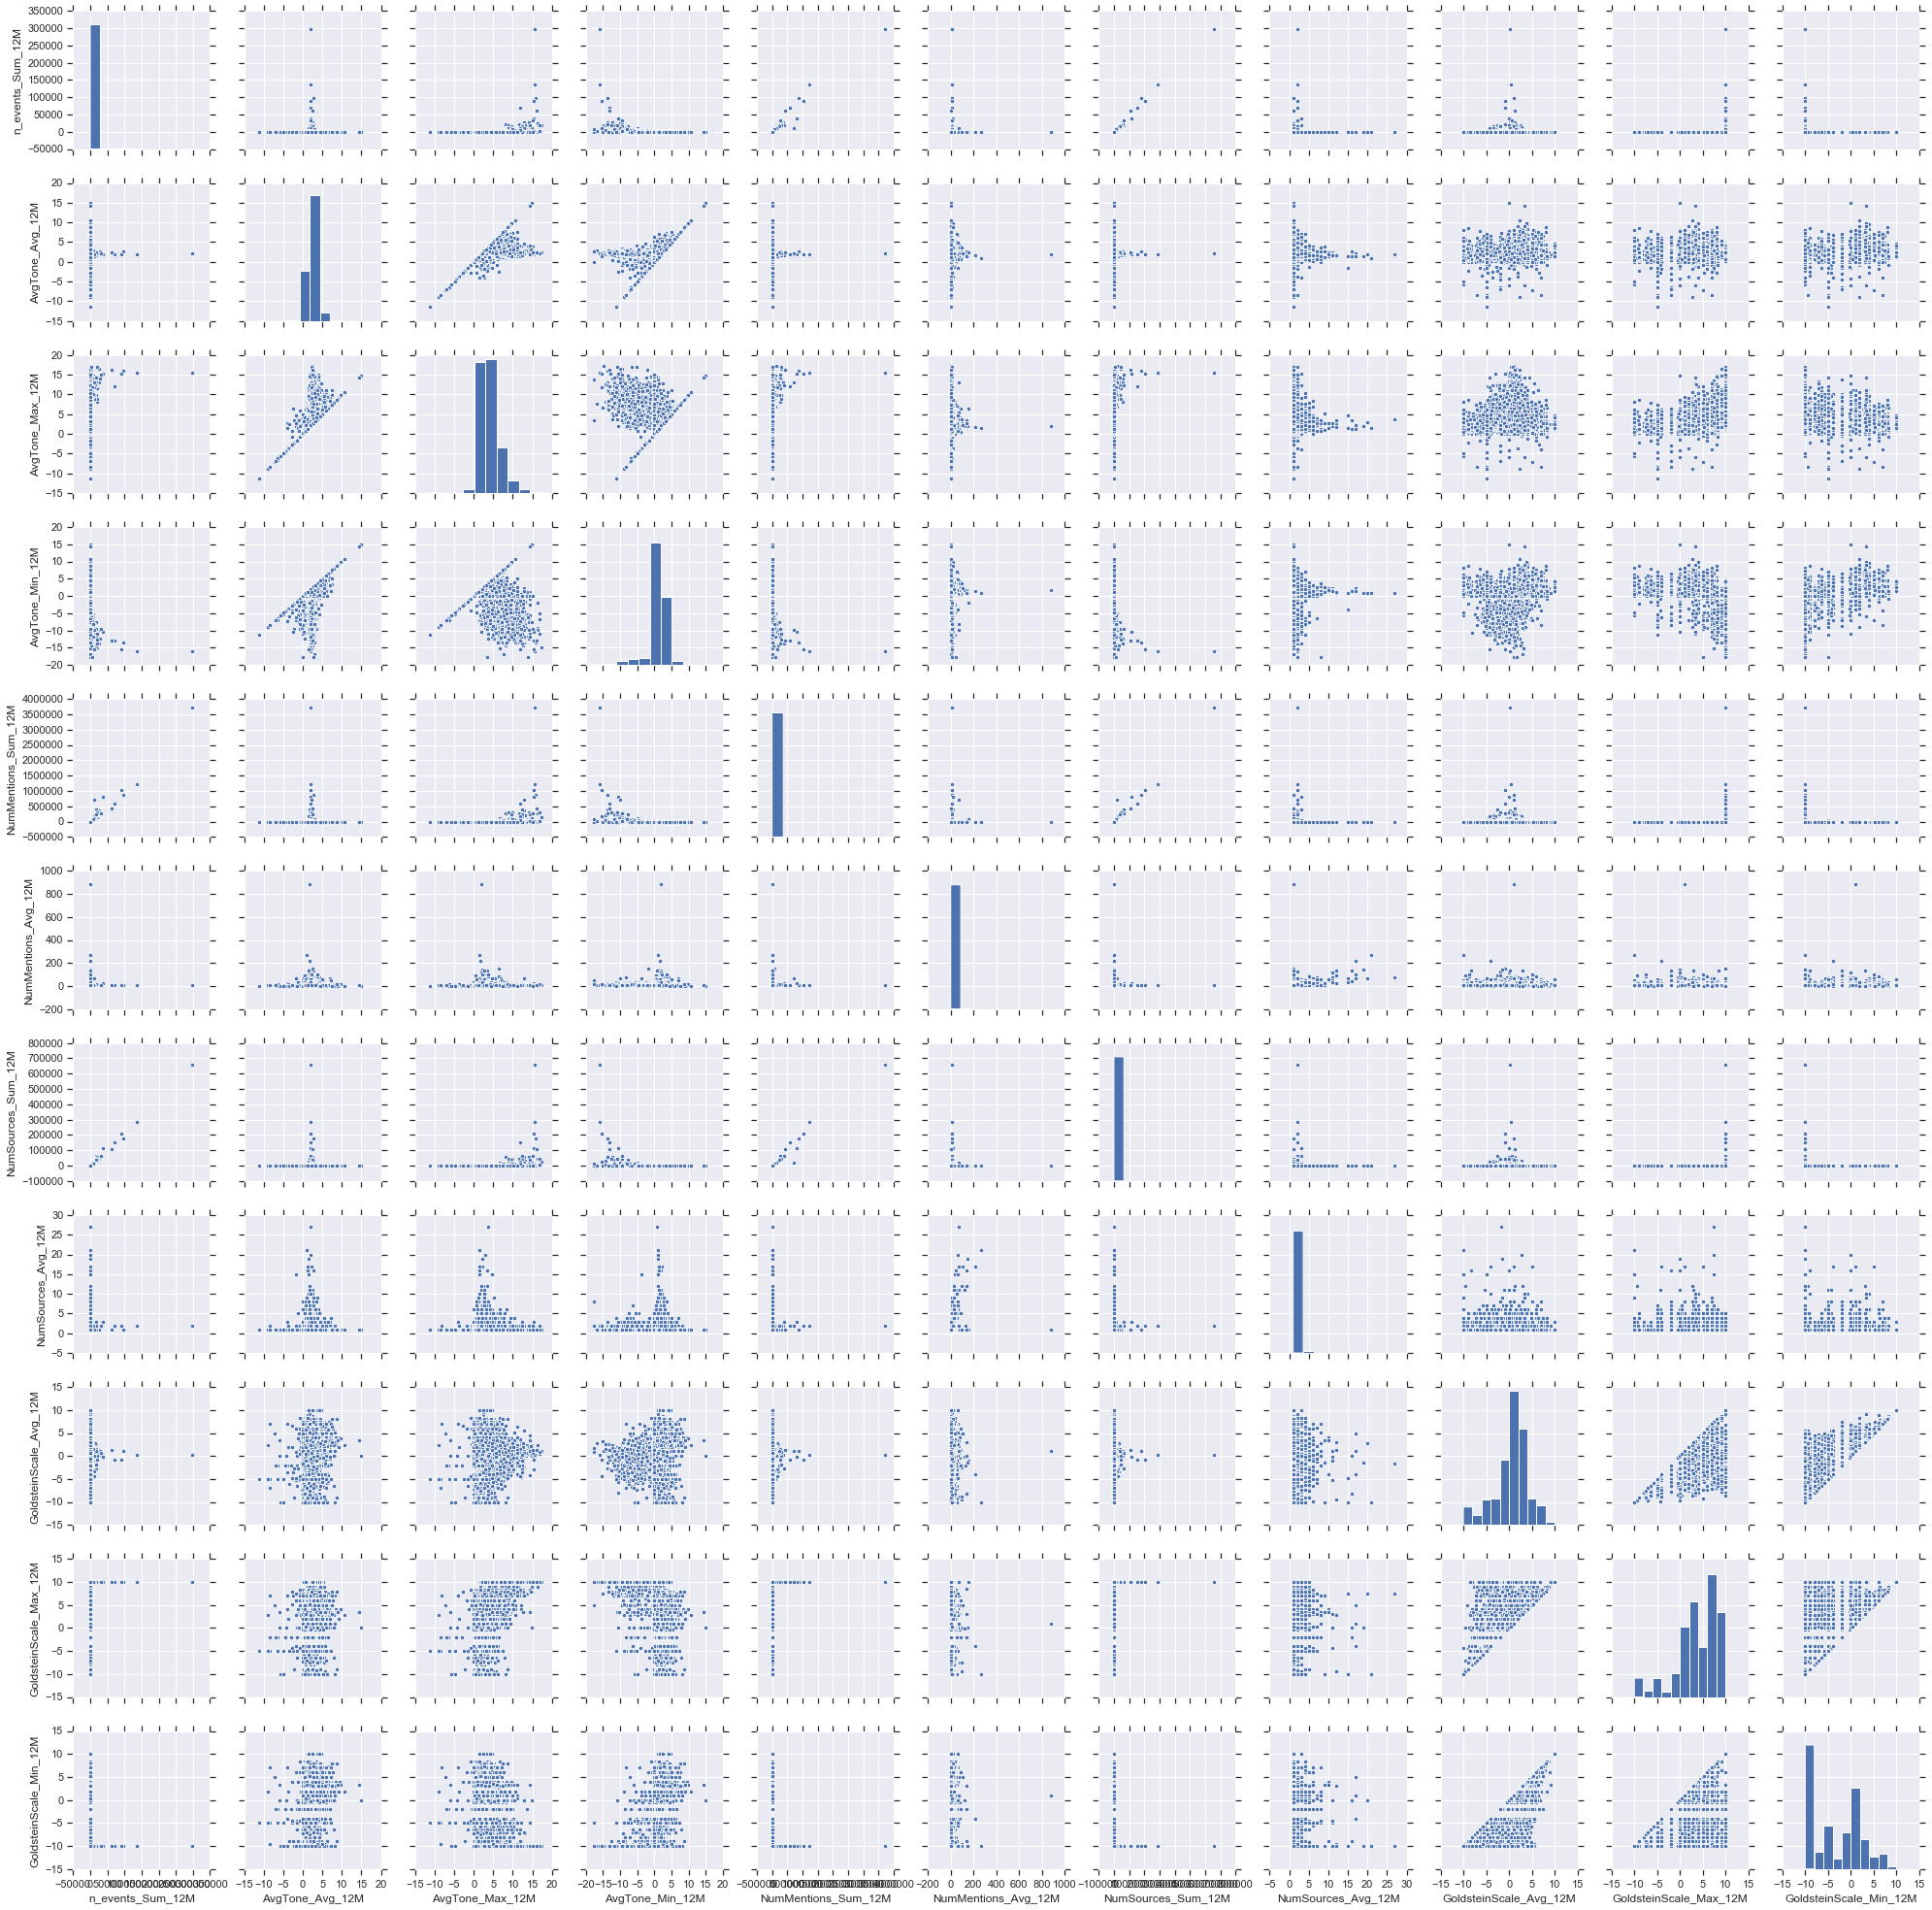

In [13]:
# Pairplot for overall overview of predictors (computation can take awhile)
sns.pairplot(data_2014)

In [14]:
# Correlation analysis of predictors
data_2014.corr()

,n_events_Sum_12M,AvgTone_Avg_12M,AvgTone_Max_12M,AvgTone_Min_12M,NumMentions_Sum_12M,NumMentions_Avg_12M,NumSources_Sum_12M,NumSources_Avg_12M,GoldsteinScale_Avg_12M,GoldsteinScale_Max_12M,GoldsteinScale_Min_12M
n_events_Sum_12M,1.000000,-0.010592,0.190097,-0.243716,0.975112,0.016632,0.996157,0.024363,0.000253,0.077447,-0.069337
AvgTone_Avg_12M,-0.010592,1.000000,0.500040,0.469109,-0.011909,-0.043701,-0.011612,-0.071446,0.189054,0.087495,0.147273
AvgTone_Max_12M,0.190097,0.500040,1.000000,-0.354460,0.180676,0.022442,0.177359,-0.014484,0.125997,0.513662,-0.391962
AvgTone_Min_12M,-0.243716,0.469109,-0.354460,1.000000,-0.235144,-0.072351,-0.232082,-0.070855,0.069232,-0.373610,0.473044
NumMentions_Sum_12M,0.975112,-0.011909,0.180676,-0.235144,1.000000,0.030657,0.983633,0.032418,-0.002018,0.073928,-0.066062
NumMentions_Avg_12M,0.016632,-0.043701,0.022442,-0.072351,0.030657,1.000000,0.018653,0.443964,-0.017382,0.040382,-0.052177
NumSources_Sum_12M,0.996157,-0.011612,0.177359,-0.232082,0.983633,0.018653,1.000000,0.030328,-0.001850,0.071625,-0.064056
NumSources_Avg_12M,0.024363,-0.071446,-0.014484,-0.070855,0.032418,0.443964,0.030328,1.000000,-0.041681,0.012638,-0.048954
GoldsteinScale_Avg_12M,0.000253,0.189054,0.125997,0.069232,-0.002018,-0.017382,-0.001850,-0.041681,1.000000,0.674986,0.633820
GoldsteinScale_Max_12M,0.077447,0.087495,0.513662,-0.373610,0.073928,0.040382,0.071625,0.012638,0.674986,1.000000,-0.034550


### Cluster analysis using k-means algorithm

In [15]:
# Selecting variables that will be used for clustering
preds_names = data_2014.columns
preds_names = preds_names.drop(['ActorId', 'obs_date'])

In [25]:
# Scaling data
scaler = preprocessing.StandardScaler().fit(data_2014[preds_names])
data_2014_scaled = scaler.transform(data_2014[preds_names])

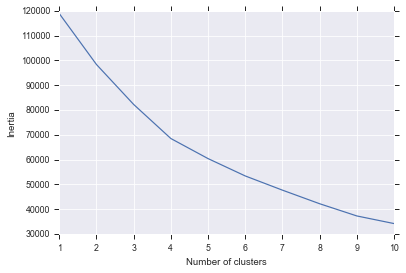

In [26]:
# Finding optimal number of clusters using inertia & Elbow method 
n_clusters = np.arange(1, 11, step = 1)
inertias = []
np.random.seed(1979)
for n in n_clusters:
    cls_actors = KMeans(init = 'k-means++', n_clusters = n)
    cls_actors.fit(data_2014_scaled)
    inertia = cls_actors.inertia_
    inertias.append(inertia) 
    
# Plotting number of clusters vs. inertia
plt.plot(n_clusters, inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

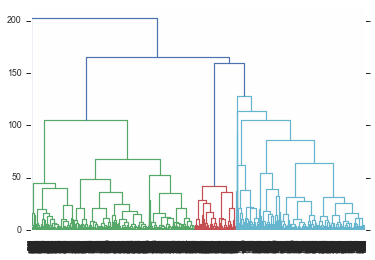

In [201]:
# Checking optimal number of clusters using dendrogram method (computation can take awhile)
import scipy.cluster.hierarchy as sch
dendogram = sch.dendrogram(sch.linkage(data_2014_scaled, method = 'ward'))
plt.figure(figsize=(40,20))
plt.show()

In [27]:
# Cluster analysis using optimal number of clusters
np.random.seed(1979)
n_clusters = 4
cls_actors = KMeans(init = 'k-means++', n_clusters = n_clusters, random_state = 1)
cl = cls_actors.fit(data_2014_scaled)

In [28]:
# Adding clustering info into original dataframe
# clusters = pd.DataFrame(cl.predict(data_2014_scaled)) # alternative way how to generate cluster labels
clusters = pd.DataFrame(cl.labels_)
clusters.columns = ['Cluster']
data_2014_analysis = pd.DataFrame(data_2014.join(clusters))

In [29]:
# Counting number of actors in individual clusters
data_2014_analysis.groupby('Cluster')['ActorId'].count()

Cluster
0    2034
1    5347
2    3427
3       1
Name: ActorId, dtype: int64

In [30]:
# Average values of predictors within individual clusters of actors
clusts = data_2014_analysis.groupby('Cluster')[preds_names].mean()
clusts.reset_index(level = 0, inplace = True)
clusts

,Cluster,n_events_Sum_12M,AvgTone_Avg_12M,AvgTone_Max_12M,AvgTone_Min_12M,NumMentions_Sum_12M,NumMentions_Avg_12M,NumSources_Sum_12M,NumSources_Avg_12M,GoldsteinScale_Avg_12M,GoldsteinScale_Max_12M,GoldsteinScale_Min_12M
0,0,3.561455,1.829397,2.168229,1.517269,3.627483e+01,7.571288,6.264503,1.265978,-5.203470,-3.551229,-6.643756
1,1,4.786048,2.646230,3.175803,2.168298,3.602338e+01,6.605947,6.437255,1.152796,2.550589,3.830297,1.101664
2,2,606.518821,2.364369,6.178912,-1.136993,6.728271e+03,8.813831,1194.029764,1.272250,0.237470,7.557193,-8.951824
3,3,297939.000000,2.053667,15.555556,-15.957447,3.709154e+06,12.000000,659463.000000,2.000000,0.288409,10.000000,-10.000000


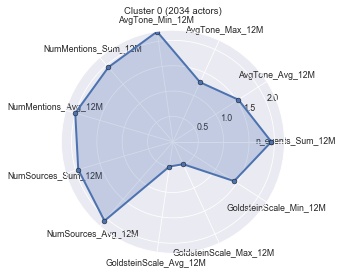

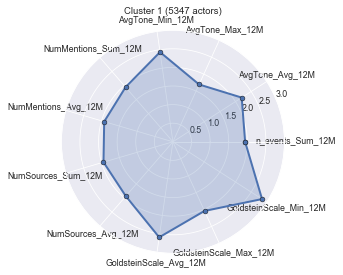

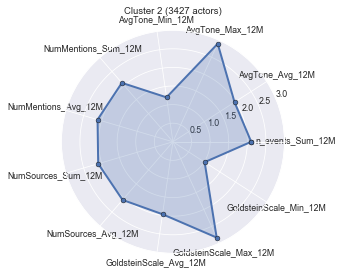

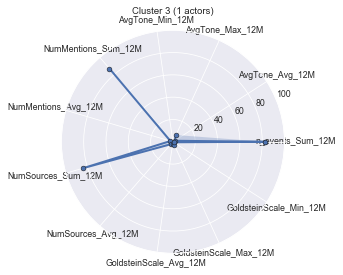

In [31]:
# Visualization of individual clusters using spider graphs
# Preparing data for spider graphs
data_2014_scaled = pd.DataFrame(data_2014_scaled)
data_2014_scaled.columns = preds_names 
data_2014_analysis_scaled = pd.DataFrame(data_2014_scaled.join(clusters))
radar_data_2014 = data_2014_analysis_scaled.groupby('Cluster')[preds_names].mean()
radar_data_2014.reset_index(level = 0, inplace = True)

# Plotting spider graphs for individual clusters  
for c in range(n_clusters):
    labels = np.array(preds_names)
    stats = radar_data_2014.loc[c, labels] + 2.0 # +2SD to enabling plotting of negative values
    n_actors = data_2014_analysis.groupby('Cluster')['ActorId'].count()[c]
    sns.set() # seaborn style
    sns.set_context("paper", font_scale = 1.0)
    fig = plt.figure()
    ax = fig.add_subplot(111, polar = True)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    ax.plot(angles, stats, 'o-', linewidth = 2)
    ax.fill(angles, stats, alpha = 0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title("Cluster %d (%d actors)" % (c, n_actors))
    ax.grid(True)
    plt.savefig("F:/space_aa_420/01_projects/2018/06_DSA_GDELT/trainees/com-lstehlik/HA3_Segmentation/spider_graphs/kmeans_spider_cluster%d.png" % c, dpi = 300)

In [32]:
# Finding 3 best examples of individuaL clusters
for j in range(n_clusters): 
    d = cl.transform(data_2014_scaled[data_2014_analysis.Cluster == j])[:, j]
    ind = np.argsort(d)[::][:3]
    print('Cluster', j, ':\n', data_2014_analysis[data_2014_analysis.Cluster == j]['ActorId'].iloc[ind])

Cluster 0 :
 4455                 INDGOV_MANIPUR
4140    IGOEUREECCVL_EUROPEAN UNION
1138                 CHLCRM_CHILEAN
Name: ActorId, dtype: object
Cluster 1 :
 1235        CHNGOV_ZHANG DEJIANG
2191    DEUGOV_GUIDO WESTERWELLE
9862             USA_PEACH STATE
Name: ActorId, dtype: object
Cluster 2 :
 1805    CVL_ETHNIC GROUP
3185      GOV_CITY MAYOR
9781           USA_CALIF
Name: ActorId, dtype: object
Cluster 3 :
 9403    UKR_UKRAINE
Name: ActorId, dtype: object


### Business interpretation of identified clusters
* **Cluster 0** 
    * Cluster with *n* = 2034 actors who have particpated on relatively small number of events that were rather destabilizing in their nature. In comparison with remaining clusters the average tone of documents mentioning events and their corresponding actors is least positive.
    * Among prototypical representatives of this cluster belong followign actors: NDGOV_MANIPUR, IGOEUREECCVL_EUROPEAN UNION and CHLCRM_CHILEAN
    * Key word/potential cluster name: Destabilization

* **Cluster 1** 
    * Cluster with *n* = 5347 actors who have been part of relatively small number of events that had rather stabilizing effect on their respective participants. In comparison with remaining clusters the average tone of documents mentioning events and their corresponding actors is most positive.
    * Among prototypical representatives of this cluster belong following actors: HNGOV_ZHANG DEJIANG, DEUGOV_GUIDO WESTERWELLE and USA_PEACH STATE.
    * Key word/potential cluster name: Stabilization
    
* **Cluster 2** 
    * Cluster with *n* = 3427 actors who have participated on relatively high number of events that were evenly distributed among those with stabilizing and destabilizing effect on their respective participants. This fact suggests that these actors could be at kind of a crossroad from which they can proceed either towards political and economic stability or towards political or economic instability.      
    * Among prototypical representatives of this cluster belong followign actors: CVL_ETHNIC GROUP, GOV_CITY MAYOR and USA_CALIF.
    * Key word/potential cluster name: At crossroad

* **Cluster 3** 
    * Cluster with just one actor who was participating on extremely large number of events. Similarly as in the case of Cluster 2 there seems to be an even mix of stabilizing and destabilizing events which suggests that Ukraine is at kind of a crossroad from which it can proceeed either towards political and economic stability or towards political or economic instability.
    * The only representative of this cluster is UKR_UKRAINE. 
    * Key word/potential cluster name: Ukraine at crossroad

### Year-over-year transition matrix for years 2014 and 2015

In [33]:
# Preparing data from 2015 for cluster assignment
data_2015_scaled = scaler.transform(data_2015[preds_names])

In [36]:
# Assigning clusters to new data points from 2015 and adding clustering info into original dataframe
clusters_2015 = pd.DataFrame(cl.predict(data_2015_scaled))
clusters_2015.columns = ['Cluster']
data_2015_analysis = data_2015.join(clusters_2015)

In [46]:
# Preparing data for transition matrix creation 
tmdata = pd.merge(left=data_2014_analysis, 
              right=data_2015_analysis, 
              how='outer', 
              left_on='ActorId', 
              right_on='ActorId', 
              suffixes=('_2014', '_2015'))

In [81]:
# Creating transition matrix
tmatrix = pd.crosstab(index = tmdata['Cluster_2014'], 
                      columns = tmdata['Cluster_2015'], 
                      margins= False, 
                      dropna=True)
tmatrix

Cluster_2015,0.0,1.0,2.0,3.0
Cluster_2014,,,,
0.0,488,266,256,0
1.0,815,1183,992,0
2.0,275,188,2844,1
3.0,0,0,1,0


In [82]:
# Saving transition matrix into excel
tmatrix.to_excel('F:/space_aa_420/01_projects/2018/06_DSA_GDELT/trainees/com-lstehlik/HA3_Segmentation/transition_matrix/transition_matrix.xlsx', 
                 index=True)